<a href="https://colab.research.google.com/github/iremnuy/Adversary_Attack_Resnet/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MI201 : attaque sur réseau de neurones à convolution**

---

Génération de bruit simple :


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


import os
import torch
import torchvision

In [ ]:
def whitenoise(width, height,n):
  return np.random.rand(width, height, n)

test :

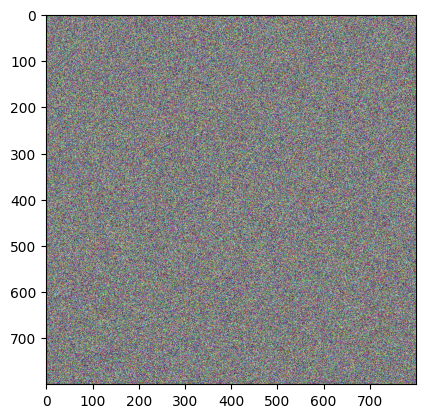

In [ ]:
plt.imshow(whitenoise(800,800,3))
plt.show()

On importe des images à classer :

<ipython-input-4-1c6b86ef2754>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load("coco_sample.pth")


torch.Size([9, 3, 520, 520])


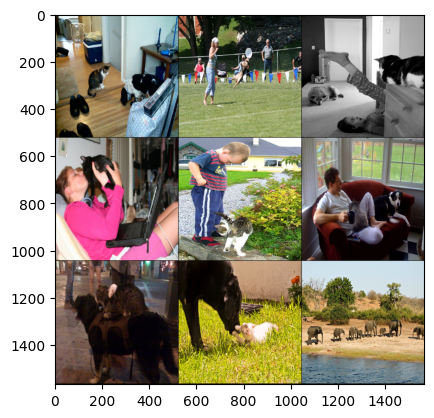

In [ ]:
if not os.path.isfile("coco_sample.pth"):
  os.system("wget https://httpmail.onera.fr/21/ceb6b35731a7561b4b34355f1803dbfdCufzJD/coco_sample.pth")

img = torch.load("coco_sample.pth")
print(img.shape)

visu = torchvision.utils.make_grid(img,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 138MB/s]


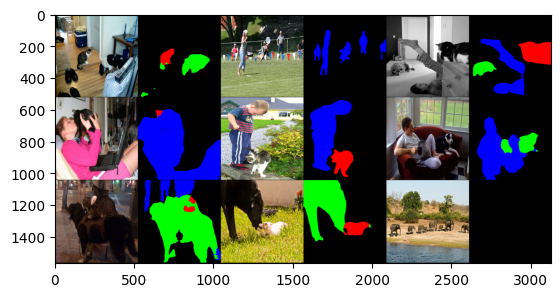

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

In [ ]:
#choose as targeted or leave null
import torch.nn.functional as F
epsilon = 10. / 255
attack_type = 'targeted'
target_class = 1  #we can choose 1(cat),2(dog) or 3(person)
attaque = torch.nn.Parameter(torch.zeros_like(x),requires_grad=True)  # we will optimize this tensor called "attaque" so we need its gradients to do a backprop.
optimizer = torch.optim.SGD([attaque], lr=0.005)

num_iterations=3

for i in range(num_iterations):
    # Forward pass with the current perturbation
    Znoised = net(normalize(x + attaque))["out"]
    Znoised = Znoised[:, [0, 8, 12, 15], :, :]  # Keep background, person, cat, and dog

    # Flatten labels and predictions for loss computation
    z_flat = z.view(-1)  # Ground truth labels
    Znoised_flat = Znoised.permute(0, 2, 3, 1).reshape(-1, Znoised.size(1))  # Logits reshaped for CrossEntropyLoss

    # Define the loss function (CrossEntropyLoss for untargeted, or MSE for targeted)
    if attack_type == 'targeted':
        target = torch.full_like(z_flat, target_class)  # Set the target class for the attack (e.g., cat)
        L = F.cross_entropy(Znoised_flat, target.view(-1))  # Targeted attack using CrossEntropyLoss
    else:
        L = -F.cross_entropy(Znoised_flat, z_flat)  # Untargeted attack: Maximize loss (minimize negative loss)

    # Zero gradients from the previous step
    optimizer.zero_grad()

    # Backpropagate the loss and calculate gradients
    L.backward()

    # Apply optimization step
    with torch.no_grad():
        # Update perturbation based on gradient sign (sign attack)
        attaque.grad = attaque.grad.sign()
        optimizer.step()

        # Clip the perturbation to keep it within an acceptable range (bounded by epsilon)
        attaque.data = torch.clamp(attaque.data, -epsilon, epsilon)

        # Ensure the perturbation stays within valid bounds relative to the original image
        lowbound = -x
        uppbound = 1 - x
        attaque.data = torch.max(torch.min(attaque.data, uppbound), lowbound)
        print(f"Iteration {i}/{num_iterations}, Loss: {L.item()}")



Iteration 0/3, Loss: 5.950838088989258
Iteration 1/3, Loss: 11.099547386169434
Iteration 2/3, Loss: 8.954976081848145


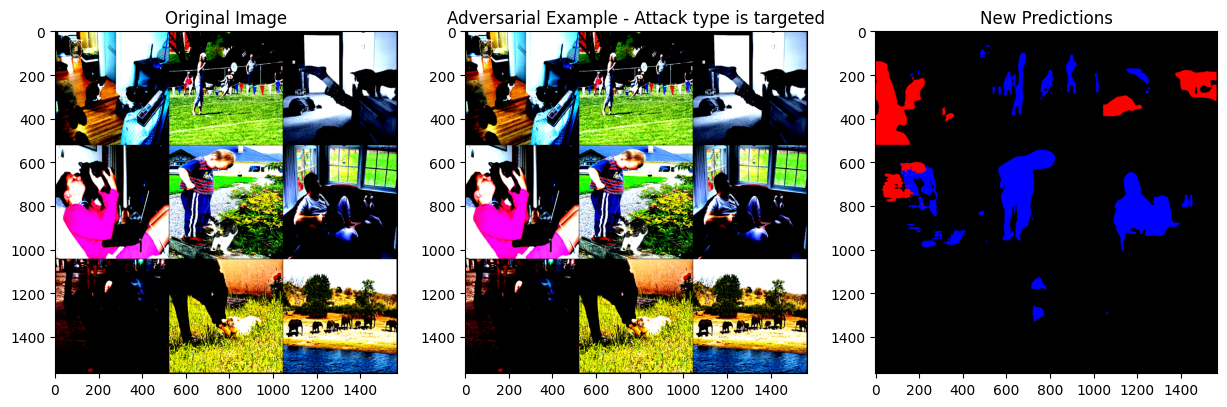

In [ ]:

# Visualize original image
plt.figure(figsize=(15, 5))  # Adjust the figure size for clarity
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(torchvision.utils.make_grid(x, nrow=3).permute(1, 2, 0).cpu().numpy())  # Ensure .cpu() for visualization

# Visualize adversarial example
plt.subplot(1, 3, 2)
plt.title("Adversarial Example - Attack type is {}".format(attack_type))
plt.imshow(torchvision.utils.make_grid(x + attaque, nrow=3).permute(1, 2, 0).cpu().numpy())

# Visualize new predictions
with torch.no_grad():
    new_preds = net(normalize(x + attaque))["out"]
    new_preds = new_preds[:, [0, 8, 12, 15], :, :].argmax(1)  # Extract new class predictions

# Convert predictions to RGB for visualization
new_pred_colors = torch.zeros_like(x)  # Start with a blank image, use `x` instead of `img`
new_pred_colors[:, 0, :, :] = (new_preds == 1).float()  # Red for "cat"
new_pred_colors[:, 1, :, :] = (new_preds == 2).float()  # Green for "dog"
new_pred_colors[:, 2, :, :] = (new_preds == 3).float()  # Blue for "person"

plt.subplot(1, 3, 3)
plt.title("New Predictions")
plt.imshow(torchvision.utils.make_grid(new_pred_colors, nrow=3).permute(1, 2, 0).cpu().numpy())  # Ensure .cpu() for visualization

plt.show()
